In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.spaceinvaders-v0.cnn"
snapshot_path = "."


#gym game title
GAME_TITLE = 'SpaceInvaders-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 10


#how long is one replay session from a batch

#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 10


In [2]:
#this is my machine-specific config. replace if are not me.

#theano device selection
%env THEANO_FLAGS='device=gpu2'


#snapshot path - where neural network snapshots are saved during the main training loop
!mkdir ./agentnet_snapshots/
snapshot_path = "./agentnet_snapshots/"


env: THEANO_FLAGS='device=gpu2'
mkdir: cannot create directory `./agentnet_snapshots/': File exists


# This tutorial is a showcase on how to use AgentNet for OpenAI Gym environments


* Space Invadets game as an example
* Training a simple lasagne neural network for Q_learning objective
 * currently we have 3 "options" depending on your alignment (see next cell)
 * we recommend you to start with a simple `dense nn`
 * as usual training a convolutional network without gpu may take long
 
* Training via simple experience replay (explained below)
* Only using utility recurrent layers for simplicity of this example
 * but adding a few RNNs or GRUs shouldn's be a problem
* the network is trained with a simple one-step Q-learning for simplicity


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

In [3]:
#Choose your side

#Sith
#mode = "simple convnet"

#Jedi
mode = "dense nn"

#Stormtrooper
#mode = "linear regression"


In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports

import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


Using gpu device 2: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [5]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game

[2016-05-01 18:06:59,370] Making new env: SpaceInvaders-v0


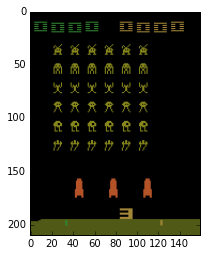

In [6]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [7]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [8]:
del atari

# agent setup step by step
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
  




##### Agent observations

* Here you define where observations (game images) appear in the network
* You can use any lasagne architecture you want. We provide several examples

In [9]:
import lasagne

from lasagne.layers import InputLayer, DropoutLayer,DenseLayer
from lasagne.layers import Conv2DLayer, MaxPool2DLayer
from lasagne.layers import flatten, dimshuffle

In [10]:


#image observation
observation_layer = InputLayer(observation_shape,
                               name="images input")

observation_reshape = dimshuffle(observation_layer,(0,3,1,2))



#convolution
if mode == 'simple convnet':
    print "Using some CNNs"
    cnn = Conv2DLayer(observation_reshape,
                                     num_filters=64,filter_size=(5,5),name='cnn0')
    cnn = MaxPool2DLayer(cnn,(5,5), name='pool0')
    cnn = Conv2DLayer(cnn,num_filters=128,filter_size=(5,5),name='cnn2')
    cnn = MaxPool2DLayer(cnn,(5,5), name='pool1')
    dnn = DropoutLayer(cnn,name = "dropout", p=0.05) #will get deterministic during evaluation
    dnn = DenseLayer(dnn,num_units=500,name='dense1')
    nn = dnn
#dense with dropout
elif mode == "dense nn":
    print "Using simple dense network"
    
    dnn = DenseLayer(observation_reshape,num_units=500,name='dense0')
    dnn = DropoutLayer(dnn,name = "dropout", p=0.05) #will get deterministic during evaluation
    dnn = DenseLayer(dnn,num_units=300,name='dense1')
    nn = dnn

#linear regression
else:
    print "Using linear model"
    nn = observation_reshape
    
#make sure layer has 2 dimensions to plug it into latter layers
flat_nn = flatten(nn,outdim=2,name='flat frame output')


Using simple dense network


  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


### In this demo
Since we have almost fully observable environment AND we want to keep baseline simple, we shall use no recurrent units.
However, Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.
To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.


In [11]:

#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation


window_size = 3


#prev state input
prev_window = InputLayer((None,window_size,flat_nn.output_shape[1]),
                                        name = "previous window state")


#our window
window = WindowAugmentation(flat_nn,prev_window,name = "new window state")



memory_dict = {window:prev_window}



##### Agent policy and action picking
* Since we are training a deep Q-network, we need it to predict Q-values and take actions.
* Hence we define a lasagne layer that is used for action output

* To pick actions, we use an epsilon-greedy resolver
  * Note that resolver outputs particular action IDs and not probabilities.
  * These actions are than sent into the environment

In [12]:
#q_eval
q_eval = DenseLayer(window,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")

#resolver
from agentnet.resolver import EpsilonGreedyResolver

epsilon = theano.shared(np.float32(0.5),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [13]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)


In [14]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[dense0.W, dense0.b, dense1.W, dense1.b, QEvaluator.W, QEvaluator.b]

# Agent step function
* computes action and next state given observation and prev state
* written in a generic way to support any recurrences, windows, LTMs, etc

In [15]:

# agent observation
applier_observation = T.tensor4("input image",dtype=floatX)


# inputs to all agent memory states (usng lasagne defaults, may use any theano inputs)
from collections import OrderedDict
applier_memories = OrderedDict([ (new_st,prev_st.input_var)
                                for new_st, prev_st in agent.state_variables.items()
                               ])

# get one-step agent interaction
res =agent.get_agent_reaction(applier_memories,
                              applier_observation,
                              deterministic = True #disable dropout here. Only enable in experience replay
                             )


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([applier_observation]+applier_memories.values(),
        applier_actions+applier_new_states)


In [16]:
#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype=floatX) 
                         for mem in agent.state_variables]
    
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [17]:
#A whole lot of space invaders

class GamePool:
    def __init__(self,game_title,n_games):
        """
        A pool that stores several
           - game states (gym environment)
           - prev_observations - last agent observations
           - prev memory states - last agent hidden states
           
       """
        
        
        self.ataries = [gym.make(game_title) for i in range(n_games)]

        self.prev_observations = [atari.reset() for atari in self.ataries]
    
        self.prev_memory_states = 'zeros'

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-05-01 18:07:01,859] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:01,888] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:01,917] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:01,946] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:01,975] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:02,003] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:02,032] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:02,061] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:02,089] Making new env: SpaceInvaders-v0
[2016-05-01 18:07:02,118] Making new env: SpaceInvaders-v0


In [18]:
# a function that creates and records environment interaction sessions
def interact(pool,n_steps = 100,verbose=False):
    """generate interaction sessions with ataries (openAI gym atari environments)
    Sessions will have length n_steps. 
    Each time one of games is finished, it is immediately getting reset"""
    history_log = []
        
    prev_observations = pool.prev_observations 
    
    prev_memory_states = pool.prev_memory_states
    
    
    
    for i in range(n_steps):
        
        actions,new_memory_states = step(prev_observations,prev_memory_states)

        
        new_observations, cur_rewards, is_done, infos = \
            zip(*map(
                     lambda atari, action: atari.step(action), 
                     pool.ataries,actions))
            
        new_observations = np.array(new_observations)
        
        for i in range(len(pool.ataries)):
            if is_done[i]:
                new_observations[i] = pool.ataries[i].reset()
                
                for m_i in range(len(new_memory_states)):
                    new_memory_states[m_i][i] = 0
                    
                if verbose:
                    print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,new_memory_states,is_done,infos))
        
        prev_observations = new_observations
        prev_memory_states = new_memory_states
                
    pool.prev_memory_states = prev_memory_states
    pool.prev_observations = prev_observations
    
    return zip(*history_log)
    

In [19]:
%%time
observation_log,action_log,reward_log,_,_,_  = interact(pool,50)


print np.array(reward_log)[:10].T
print np.array(action_names)[np.array(action_log)[:3,:5]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['FIRE' 'RIGHTFIRE' 'LEFT' 'FIRE' 'RIGHTFIRE']
 ['LEFT' 'FIRE' 'NOOP' 'FIRE' 'RIGHT']
 ['LEFTFIRE' 'LEFT' 'FIRE' 'FIRE' 'FIRE']]
CPU times: user 932 ms, sys: 148 ms, total: 1.08 s
Wall time: 1.08 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [20]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=[])

In [21]:
def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    
    observation_log,action_log,reward_log,_,is_done_log,_= interact(pool,n_steps=n_steps)
    
    
    #tensor dimensions
    
    # [batch_i, time_i, width, height, rgb]
    observation_tensor = np.array(observation_log).swapaxes(0,1)
    
    # [batch_i,time_i]
    action_tensor = np.array(action_log).swapaxes(0,1)
    
    # [batch_i, time_i]
    reward_tensor = np.array(reward_log).swapaxes(0,1)

    # [batch_i, time_i]
    is_alive_tensor = 1- np.array(is_done_log,dtype = 'int8').swapaxes(0,1)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[])
    
    

In [22]:
#load first  sessions
update_pool(env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [23]:
#produce interaction sequences of length <= 10

_,observation_seq,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
)


#observation seq are the observation tensor we just loaded
#qvalues seq are agent's Qvalues obtained via experience replay


#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now

#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [24]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.99),name = 'q_learning_gamma')


#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = rewards_seq
#For SpaceInvaders, however, not scaling rewards is at least working


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        action_seq,
                                                        rewards_seq,
                                                        is_alive_seq,
                                                        gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / is_alive_seq.sum()

In [25]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [26]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [27]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [28]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [29]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# Session visualization tools

__[warning, this thing basicly tries to track various Qvalues over time]__

__[but it's bulky and stupid, so don't try to understand it if it didn't come naturally]__


* this is a completely optional step of visualizing agent's sessions as chains of actions
* in this function, we display game image and than print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward | next iteration
  * each block represents agent's decision in a single time step following the shown game state 

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]

At the beginning, agent knows nothing (Jon) and behaves randomly


In [30]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3,update = True):
    
    pictures = [atari.render("rgb_array") for atari in pool.ataries[:max_n_sessions]]
    
    if update:
        update_pool(env,pool,replay_seq_len)
    
    
    printables = get_printables()
    
    
    for i in range(max_n_sessions):
        plt.imshow(pictures[i])
        plt.show()
            
        qvalues_log,actions_log,reward_log, is_alive_log = map(lambda v: np.array(v[i:i+1]), printables)
        

        print_sessions(qvalues_log,actions_log,reward_log,
                       is_alive_seq = is_alive_log,
                       action_names=action_names,
                       legend = True, #do not show legend since there's too many labeled objects
                      plot_policy = with_plots)

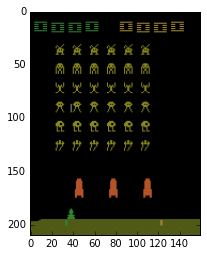

session # 0
 FIRE(qv = 0.0) -> 0.0 |  FIRE(qv = 20.231924057) -> 0.0 |  FIRE(qv = 47.5489959717) -> 0.0 |  FIRE(qv = 56.6224822998) -> 0.0 |  FIRE(qv = 53.1013565063) -> 0.0 |  FIRE(qv = 60.61901474) -> 0.0 |  FIRE(qv = 40.7393836975) -> 0.0 |  FIRE(qv = 57.3094596863) -> 0.0 |  FIRE(qv = 61.5535354614) -> 0.0 |  LEFT(qv = 68.4480743408) -> 0.0 | reached max session length


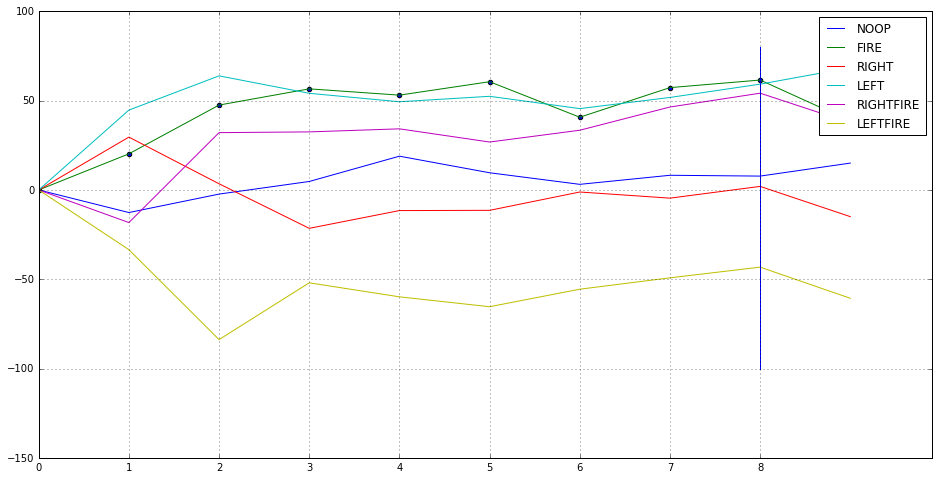

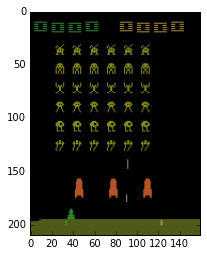

session # 0
 FIRE(qv = 0.0) -> 0.0 |  LEFTFIRE(qv = -28.6804504395) -> 0.0 |  FIRE(qv = 44.1978797913) -> 0.0 |  FIRE(qv = 42.3671188354) -> 0.0 |  FIRE(qv = 46.80991745) -> 0.0 |  FIRE(qv = 49.6835403442) -> 0.0 |  LEFT(qv = 78.0213165283) -> 0.0 |  LEFT(qv = 62.063117981) -> 0.0 |  LEFT(qv = 43.3951377869) -> 0.0 |  LEFT(qv = 71.8913192749) -> 0.0 | reached max session length


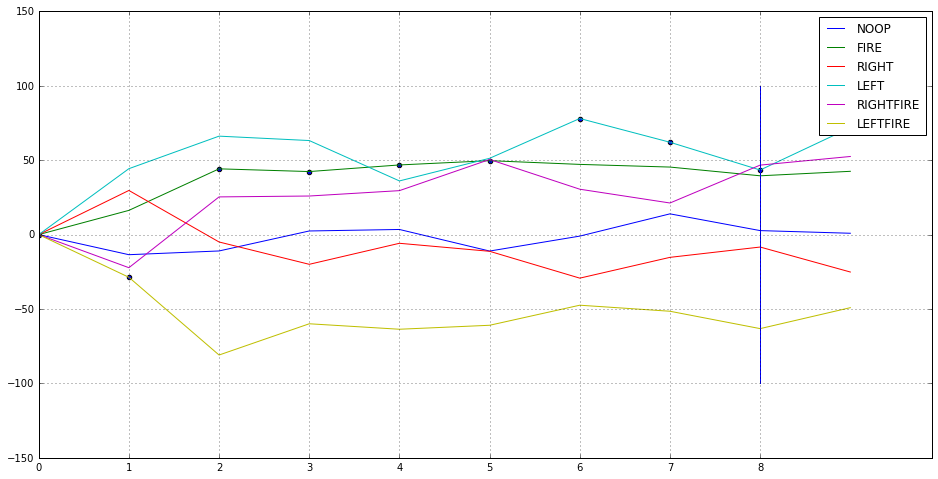

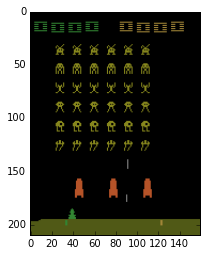

session # 0
 FIRE(qv = 0.0) -> 0.0 |  FIRE(qv = 30.4985084534) -> 0.0 |  FIRE(qv = 71.3071746826) -> 0.0 |  FIRE(qv = 58.7176361084) -> 0.0 |  FIRE(qv = 57.0654220581) -> 0.0 |  FIRE(qv = 66.3515167236) -> 0.0 |  LEFT(qv = 71.7498092651) -> 0.0 |  LEFT(qv = 79.5611724854) -> 0.0 |  LEFT(qv = 75.5402374268) -> 0.0 |  LEFT(qv = 51.0614776611) -> 0.0 | reached max session length


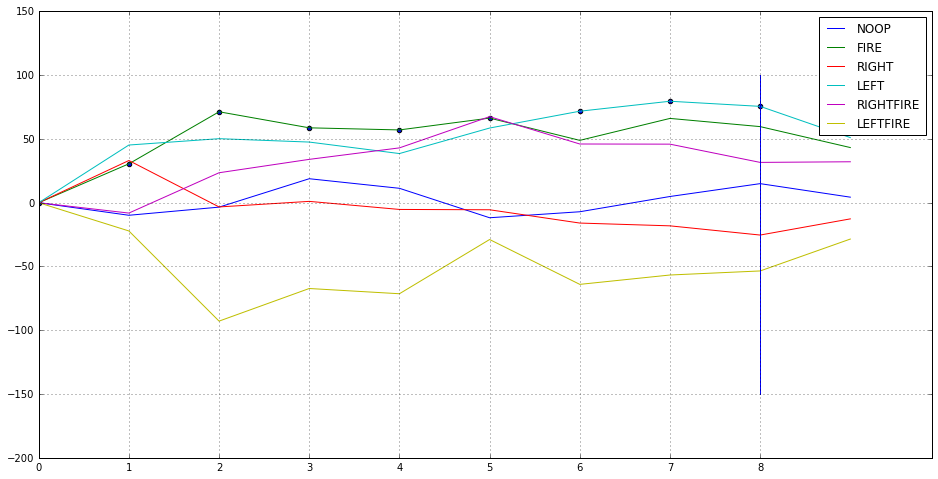

In [31]:
#visualize untrained network performance (which is mostly random)
epsilon.set_value(0.05)
display_sessions(with_plots=True)

# Training loop

In [32]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [33]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 50,loss 7140.12775, epsilon 0.47805, rewards: ( e-greedy 0.90000, greedy 0.15000) 
rec 7139.990 reg 0.138
epoch 100,loss 2335.10430, epsilon 0.45718, rewards: ( e-greedy 0.96000, greedy 0.23500) 
rec 2334.966 reg 0.138
epoch 150,loss 1318.85880, epsilon 0.43732, rewards: ( e-greedy 0.91400, greedy 0.36150) 
rec 1318.721 reg 0.138
epoch 200,loss 774.55514, epsilon 0.41843, rewards: ( e-greedy 1.07260, greedy 0.32535) 
rec 774.417 reg 0.138
epoch 250,loss 500.32744, epsilon 0.40046, rewards: ( e-greedy 1.06534, greedy 0.74282) 
rec 500.189 reg 0.138
epoch 300,loss 408.33084, epsilon 0.38337, rewards: ( e-greedy 0.95881, greedy 0.96853) 
rec 408.193 reg 0.138
epoch 350,loss 300.19875, epsilon 0.36711, rewards: ( e-greedy 1.41293, greedy 0.87168) 
rec 300.061 reg 0.138
epoch 400,loss 120.00155, epsilon 0.35164, rewards: ( e-greedy 1.32163, greedy 0.78451) 
rec 119.864 reg 0.138
epoch 450,loss 116.86354, epsilon 0.33693, rewards: ( e-greedy 1.63947, greedy 0.75606) 
rec 116.726 reg 0.

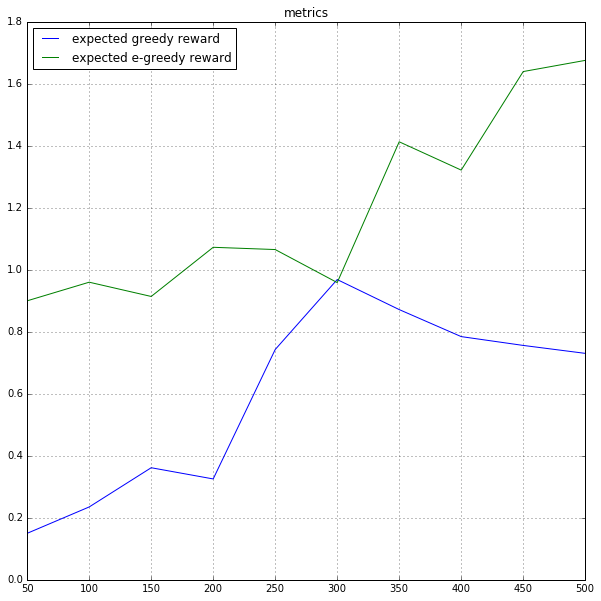

Random session examples


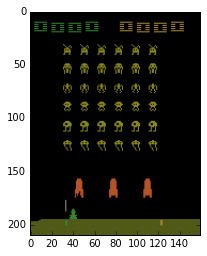

session # 0
 LEFT(qv = 0.0599422603846) -> 5.0 |  FIRE(qv = 18.8668308258) -> 0.0 |  RIGHT(qv = 16.4909648895) -> 0.0 |  LEFTFIRE(qv = 16.5073757172) -> 0.0 |  RIGHTFIRE(qv = 11.3514699936) -> 0.0 |  LEFTFIRE(qv = 16.7062683105) -> 0.0 |  LEFTFIRE(qv = 19.0807247162) -> 0.0 |  LEFTFIRE(qv = 15.9959840775) -> 0.0 |  LEFTFIRE(qv = 16.1991596222) -> 0.0 |  FIRE(qv = 7.97251987457) -> 0.0 | reached max session length


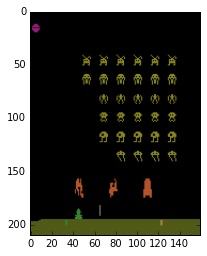

session # 0
 RIGHTFIRE(qv = 0.0450952276587) -> 0.0 |  FIRE(qv = 19.0880641937) -> 0.0 |  RIGHTFIRE(qv = 19.2019672394) -> 0.0 |  RIGHT(qv = 18.4719085693) -> 0.0 |  RIGHT(qv = 18.9853954315) -> 0.0 |  NOOP(qv = 7.6367726326) -> 0.0 |  RIGHT(qv = 14.8650074005) -> 0.0 |  LEFT(qv = 17.6879577637) -> 0.0 |  RIGHT(qv = 17.7478904724) -> 0.0 |  RIGHTFIRE(qv = 12.8083095551) -> 0.0 | reached max session length


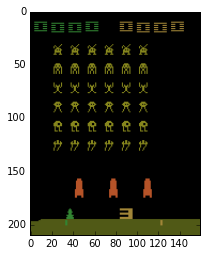

session # 0
 RIGHT(qv = 0.0503041706979) -> 0.0 |  LEFT(qv = 18.2264575958) -> 0.0 |  LEFT(qv = 21.7758464813) -> 0.0 |  LEFT(qv = 17.3608932495) -> 0.0 |  LEFT(qv = 25.7723522186) -> 0.0 |  LEFT(qv = 21.0897541046) -> 0.0 |  LEFT(qv = 19.4524497986) -> 0.0 |  LEFT(qv = 18.045665741) -> 0.0 |  LEFT(qv = 21.3150100708) -> 0.0 |  FIRE(qv = 8.30811691284) -> 0.0 | reached max session length
epoch 550,loss 77.03663, epsilon 0.30963, rewards: ( e-greedy 2.10797, greedy 0.80741) 
rec 76.899 reg 0.138
epoch 600,loss 182.92690, epsilon 0.29697, rewards: ( e-greedy 2.04717, greedy 1.32667) 
rec 182.789 reg 0.138
epoch 650,loss 75.82517, epsilon 0.28492, rewards: ( e-greedy 2.14246, greedy 1.69400) 
rec 75.687 reg 0.138
epoch 700,loss 33.94069, epsilon 0.27346, rewards: ( e-greedy 1.92821, greedy 1.97460) 
rec 33.803 reg 0.138
epoch 750,loss 35.41203, epsilon 0.26256, rewards: ( e-greedy 1.73539, greedy 1.77714) 
rec 35.274 reg 0.138
epoch 800,loss 53.30395, epsilon 0.25220, rewards: ( e-greedy 

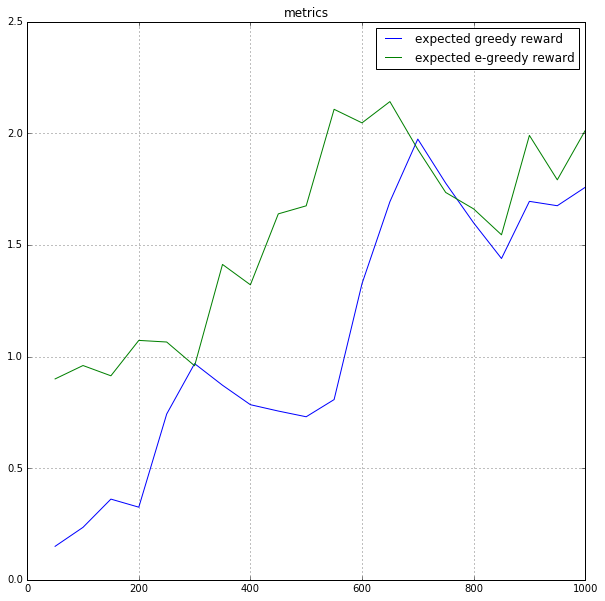

Random session examples


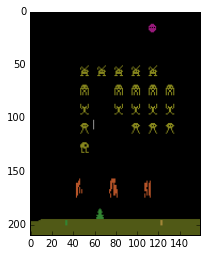

session # 0
 RIGHTFIRE(qv = 0.116529390216) -> 0.0 |  RIGHTFIRE(qv = 10.1334562302) -> 0.0 |  RIGHTFIRE(qv = 12.0244884491) -> 0.0 |  RIGHTFIRE(qv = 9.99493026733) -> 0.0 |  RIGHTFIRE(qv = 8.46597099304) -> 0.0 |  NOOP(qv = 10.3081169128) -> 0.0 |  FIRE(qv = 10.796456337) -> 0.0 |  FIRE(qv = 10.8547677994) -> 0.0 |  NOOP(qv = 6.25709867477) -> 0.0 |  NOOP(qv = 11.1681156158) -> 0.0 | reached max session length


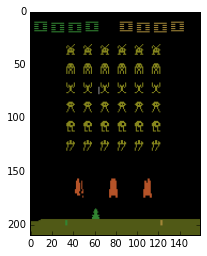

session # 0
 LEFT(qv = 0.157022997737) -> 0.0 |  RIGHTFIRE(qv = 14.170126915) -> 0.0 |  FIRE(qv = 10.5243015289) -> 0.0 |  LEFTFIRE(qv = 10.0056190491) -> 0.0 |  FIRE(qv = 12.234418869) -> 0.0 |  RIGHTFIRE(qv = 7.09138584137) -> 0.0 |  LEFTFIRE(qv = 10.2607793808) -> 0.0 |  LEFTFIRE(qv = 12.4318628311) -> 0.0 |  FIRE(qv = 14.0166969299) -> 0.0 |  NOOP(qv = 13.4693984985) -> 0.0 | reached max session length


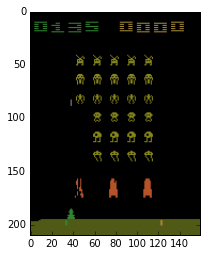

session # 0
 RIGHT(qv = 0.136092841625) -> 0.0 |  LEFTFIRE(qv = 5.26750040054) -> 0.0 |  RIGHT(qv = 8.61124134064) -> 0.0 |  NOOP(qv = 7.91053628922) -> 0.0 |  RIGHT(qv = 8.90178108215) -> 0.0 |  RIGHTFIRE(qv = 9.32580661774) -> 0.0 |  RIGHT(qv = 8.47615814209) -> 0.0 |  RIGHT(qv = 9.4924325943) -> 0.0 |  RIGHTFIRE(qv = 7.15473985672) -> 0.0 |  NOOP(qv = 8.40894889832) -> 0.0 | reached max session length
saved ./agentnet_snapshots/tutorial.gym.atari.spaceinvaders-v0.cnn.epoch1000.pcl
epoch 1050,loss 15.56163, epsilon 0.20747, rewards: ( e-greedy 2.01151, greedy 1.68255) 
rec 15.424 reg 0.138
epoch 1100,loss 9.30012, epsilon 0.19979, rewards: ( e-greedy 2.01036, greedy 1.86429) 
rec 9.162 reg 0.138
epoch 1150,loss 8.40446, epsilon 0.19249, rewards: ( e-greedy 1.85932, greedy 1.67786) 
rec 8.267 reg 0.138
epoch 1200,loss 4.02754, epsilon 0.18554, rewards: ( e-greedy 1.67339, greedy 1.71008) 
rec 3.890 reg 0.138
epoch 1250,loss 2.56877, epsilon 0.17893, rewards: ( e-greedy 1.50605, greedy

In [ ]:
#25k may take hours to train.
#consider less epochs for your first eval (or interrupt early)
n_epochs = 25000



for i in range(n_epochs):    
    
    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %500 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %1000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
score_log.plot("final")

In [ ]:
print "Random session examples"
display_sessions(with_plots=True)


# Submission

In [40]:
epsilon.set_value(0)

In [45]:

save_path = '/tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(200):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = [np.zeros((1,)+tuple(mem.output_shape[1:]),dtype=floatX) 
                         for mem in agent.state_variables]
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories)
        observation, reward, done, info = subm_env.step(action)
        
        prev_memories = new_memories
        if done:
            print "Episode finished after {} timesteps".format(t+1)
            break
        t+=1

subm_env.monitor.close()

[2016-05-01 11:09:30,800] Making new env: SpaceInvaders-v0
[2016-05-01 11:09:30,831] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 809 timesteps
Episode finished after 1227 timesteps
Episode finished after 661 timesteps
Episode finished after 566 timesteps
Episode finished after 577 timesteps
Episode finished after 559 timesteps
Episode finished after 561 timesteps
Episode finished after 703 timesteps
Episode finished after 948 timesteps
Episode finished after 1457 timesteps
Episode finished after 727 timesteps
Episode finished after 787 timesteps
Episode finished after 604 timesteps
Episode finished after 679 timesteps
Episode finished after 1159 timesteps
Episode finished after 716 timesteps
Episode finished after 660 timesteps
Episode finished after 527 timesteps
Episode finished after 1274 timesteps
Episode finished after 1088 timesteps
Episode finished after 1168 timesteps
Episode finished after 844 timesteps
Episode finished after 1139 timesteps
Episode finished after 1245 timesteps
Episode finished after 933 timesteps
Episode finished after 1108 timesteps
Episode finished after 598 ti

[2016-05-01 11:21:44,957] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0')


Episode finished after 697 timesteps


In [46]:
gym.monitoring._monitors.clear()

In [47]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)


[2016-05-01 11:21:44,997] [SpaceInvaders-v0] Uploading 200 episodes of training data
/home/jheuristic/thenv/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/home/jheuristic/thenv/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/jheuristic/thenv/local/lib/python2.7

<Evaluation evaluation id=eval_m11Mvf9ZSAiVyApy42P17Q at 0x3125ae90> JSON: {
  "created": 1462101708, 
  "env": "SpaceInvaders-v0", 
  "id": "eval_m11Mvf9ZSAiVyApy42P17Q", 
  "object": "evaluation"
}